## Librairies

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score  
from itertools import product
from tensorflow.keras.metrics import Recall
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight

2025-10-21 13:31:58.116209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761053518.282776      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761053518.343281      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Parametres

In [2]:
# Paramètres
multiclass = False   # Pour choisir si on veut prédire juste la présence d'anévrismes ou la localisation des anévrismes
epochs = 50
patience = 10

# Grille
dropouts = [0.1, 0.2, 0.3]
learning_rates = [1e-4, 5e-4, 1e-5]
batch_sizes = [16, 32]
optimizers = ["adam", "rmsprop"]
data_augmentation_list = [False, True]

## Données

In [3]:
# Chargement des données sauvegardées
x_images = np.load('/kaggle/input/images/x_images.npy')
y_labels = np.load('/kaggle/input/images/y_labels.npy')

In [4]:
x_images.shape

(4026, 256, 256, 5)

In [5]:
# Garder uniquement la première modalité
# liste_techniques = ["MIP",  "Variance", "Std", "Entropy", "Energy"]
# Pour MIP mettre [..., 0:1], pour variance [..., 1:2], pour std [..., 2:3], pour energy [..., 4:5]  (entropy semble ne pas fonctionner correctement)
x_images = x_images[..., 0:1]

In [6]:
# Pour vérifier la normalisation des données
print("Min :", x_images.min())
print("Max :", x_images.max())
print("Mean :", x_images.mean())
print("Std :", x_images.std())

Min : 0.0
Max : 1.0
Mean : 0.28220877
Std : 0.27041653


In [7]:
if multiclass:
    num_classes = y_labels.shape[1]
    y_data = y_labels.astype(np.float32)
else:
    nothing_index = 8
    y_data = 1 - y_labels[:, nothing_index]
    y_data = y_data.astype(np.float32)
    num_classes = 1

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x_images, y_data,
    test_size=0.4,
    shuffle=True,
    stratify=y_data if not multiclass else np.argmax(y_data, axis=1),
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    stratify=y_train if not multiclass else np.argmax(y_train, axis=1),
    random_state=42
)

In [9]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(1932, 256, 256, 1)
(1611, 256, 256, 1)
(483, 256, 256, 1)


In [ ]:
# augmentation de données
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

## Modele

In [ ]:
def build_model(dropout_rate=0.1, lr=1e-4, optimizer_name="adam"):
    model = Sequential([

        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(x_images.shape[1], x_images.shape[2], x_images.shape[3])),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
    ])

    # Ajout de la couche de sortie en fonction du type de classification
    if multiclass:
        model.add(Dense(num_classes, activation='softmax'))
        loss_fn = 'categorical_crossentropy'
    else:
        model.add(Dense(1, activation='sigmoid'))
        loss_fn = 'binary_crossentropy'

    # Choix de l'optimiseur
    if optimizer_name.lower() == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        raise ValueError("Optimizer non supporté")

    # Compilation du modèle
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', Recall()])

    return model

In [ ]:
def build_model_unet(dropout_rate=0.1, lr=1e-4, optimizer_name="adam"):
    inputs = Input(shape=(x_images.shape[1], x_images.shape[2], x_images.shape[3]))

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    bn = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    bn = BatchNormalization()(bn)
    bn = Dropout(dropout_rate)(bn)
    bn = Conv2D(256, (3, 3), activation='relu', padding='same')(bn)

    # Option 1 : classification via global pooling
    x = GlobalAveragePooling2D()(bn)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    if multiclass:
        output = Dense(num_classes, activation='softmax')(x)
        loss_fn = 'categorical_crosse
    else:
        output = Dense(1, activation='sigmoid')(x)
        loss_fn = 'binary_crossentropy'

    model = Model(inputs=inputs, outputs=output)

    if optimizer_name.lower() == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        raise ValueError("Optimizer non supporté")

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', Recall()])
    return model

In [12]:
if multiclass:
    y_classes = np.argmax(y_data, axis=1)
    classes = np.unique(y_classes)
else:
    y_classes = y_data.astype(int)
    classes = np.unique(y_classes)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_classes)
class_weight_dict = dict(zip(classes, class_weights))

print("Poids des classes :", class_weight_dict)

Poids des classes : {0: 0.8733188720173536, 1: 1.1696687972109239}


## Entrainement sur grille

In [13]:
results = []

for dropout, lr, batch_size, optimizer_name, data_augmentation in product(dropouts, learning_rates, batch_sizes, optimizers, data_augmentation_list):
    print(f"\n=== Testing: dropout={dropout}, lr={lr}, batch_size={batch_size}, optimizer={optimizer_name} ===")
    
    tf.keras.backend.clear_session()
    gc.collect()
    
    model = build_model(dropout_rate=dropout, lr=lr, optimizer_name=optimizer_name)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)
    
    if data_augmentation:
        try:
            history = model.fit(
                    datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    callbacks=[early_stop],
                    class_weight=class_weight_dict,
                    verbose=0
                )
        except tf.errors.ResourceExhaustedError as e:
            print(f"OOM error with config: dropout={dropout}, lr={lr}, batch_size={batch_size}, optimizer={optimizer_name}, aug={data_augmentation}")
            continue

    else:
        try:
            history = model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stop],
            class_weight=class_weight_dict,
            verbose=0
        )
        except tf.errors.ResourceExhaustedError as e:
            print(f"OOM error with config: dropout={dropout}, lr={lr}, batch_size={batch_size}, optimizer={optimizer_name}, aug={data_augmentation}")
            continue
        
    
    val_acc = max(history.history['val_accuracy'])
    val_loss = min(history.history['val_loss'])
    val_recall = max(history.history['val_recall'])
    epochs_ran = len(history.history['loss'])
    
    results.append({
        "dropout": dropout,
        "lr": lr,
        "batch_size": batch_size,
        "optimizer": optimizer_name,
        "val_acc": val_acc,
        "data_augmentation" : data_augmentation,
        "val_loss": val_loss,
        "val_recall": val_recall,
        "epochs": epochs_ran
    })
    print(f" -> val_acc={val_acc:.4f}, val_loss={val_loss:.4f}, epochs={epochs_ran:.4f}")

df_results = pd.DataFrame(results).sort_values(by="val_acc", ascending=False)
best_params = df_results.iloc[0]
print("\n=== Best Parameters ===")
print(best_params)


=== Testing: dropout=0.1, lr=0.0001, batch_size=16, optimizer=adam ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761053560.067434      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1761053568.253748      60 service.cc:148] XLA service 0x7cb7d40041f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761053568.254461      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761053568.869257      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761053575.507657      60 devic

 -> val_acc=0.6004, val_loss=0.7274, epochs=16.0000

=== Testing: dropout=0.1, lr=0.0001, batch_size=16, optimizer=adam ===


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 -> val_acc=0.6025, val_loss=0.6722, epochs=16.0000

=== Testing: dropout=0.1, lr=0.0001, batch_size=16, optimizer=rmsprop ===
 -> val_acc=0.6087, val_loss=0.7274, epochs=17.0000

=== Testing: dropout=0.1, lr=0.0001, batch_size=16, optimizer=rmsprop ===
 -> val_acc=0.5859, val_loss=0.7054, epochs=18.0000

=== Testing: dropout=0.1, lr=0.0001, batch_size=32, optimizer=adam ===
 -> val_acc=0.5859, val_loss=0.7410, epochs=16.0000

=== Testing: dropout=0.1, lr=0.0001, batch_size=32, optimizer=adam ===
 -> val_acc=0.5776, val_loss=0.6995, epochs=31.0000

=== Testing: dropout=0.1, lr=0.0001, batch_size=32, optimizer=rmsprop ===
 -> val_acc=0.5797, val_loss=0.6849, epochs=12.0000

=== Testing: dropout=0.1, lr=0.0001, batch_size=32, optimizer=rmsprop ===
 -> val_acc=0.5839, val_loss=0.7147, epochs=11.0000

=== Testing: dropout=0.1, lr=0.0005, batch_size=16, optimizer=adam ===
 -> val_acc=0.5818, val_loss=0.6810, epochs=13.0000

=== Testing: dropout=0.1, lr=0.0005, batch_size=16, optimizer=adam 

## Entrainement meilleur modele

In [14]:
tf.keras.backend.clear_session()
gc.collect()

model = build_model(dropout_rate=best_params['dropout'], lr=best_params['lr'], optimizer_name=best_params['optimizer'])
early_stop = EarlyStopping(monitor='loss', patience=3*patience, restore_best_weights=True, verbose=1)

if best_params['data_augmentation']:
    history = model.fit(
        datagen.flow(np.concatenate([x_train, x_val]), np.concatenate([y_train, y_val]), batch_size=int(best_params['batch_size'])),
        epochs=best_params['epochs'],
     #   callbacks=[early_stop],
        class_weight=class_weight_dict,
        verbose=1
    )
else:
    history = model.fit(
        np.concatenate([x_train, x_val]), np.concatenate([y_train, y_val]),
        batch_size=int(best_params['batch_size']),
        epochs=best_params['epochs'],
      #  callbacks=[early_stop],
        class_weight=class_weight_dict,
        verbose=1
    )

Epoch 1/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.5071 - loss: 0.8848 - recall: 0.4848
Epoch 2/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5610 - loss: 0.7662 - recall: 0.5788
Epoch 3/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5734 - loss: 0.7241 - recall: 0.5382
Epoch 4/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5794 - loss: 0.7210 - recall: 0.5821
Epoch 5/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5836 - loss: 0.7001 - recall: 0.5692
Epoch 6/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6104 - loss: 0.6867 - recall: 0.5889
Epoch 7/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6265 - loss: 0.6534 - recall: 0.6169
Epoch 8/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6398 - loss: 0.6749 - recall: 0.6357
Epoch 9/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6711 - loss: 0.6102 - recall: 0.6702
Epoch 10/14
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accurac

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,872,516 (33.85 MB)

 Trainable params: 4,435,777 (16.92 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 4,435,779 (16.92 MB)

## Résultats

In [16]:
# =========================
# Évaluation sur le jeu de test
# =========================
y_pred_prob = model.predict(x_test)
if multiclass:
    # Prédiction des classes (multiclasses)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
else:
    # Prédiction binaire
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_true = y_test.astype(int).flatten()

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


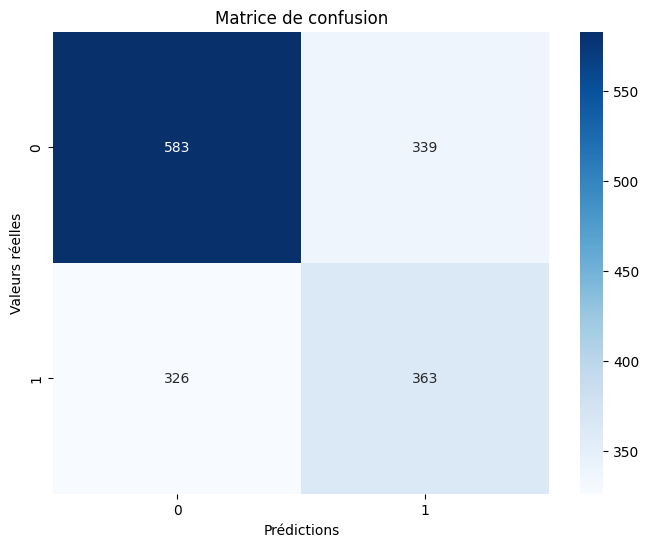

In [17]:
# =========================
# Matrice de confusion
# =========================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()

In [18]:
# =========================
# Rapport de classification
# =========================
print(f"Accuracy sur le jeu de test : {accuracy_score(y_true, y_pred):.4f}")
print("\n=== Rapport de classification ===")
print(classification_report(y_true, y_pred))

Accuracy sur le jeu de test : 0.5872

=== Rapport de classification ===
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       922
           1       0.52      0.53      0.52       689

    accuracy                           0.59      1611
   macro avg       0.58      0.58      0.58      1611
weighted avg       0.59      0.59      0.59      1611



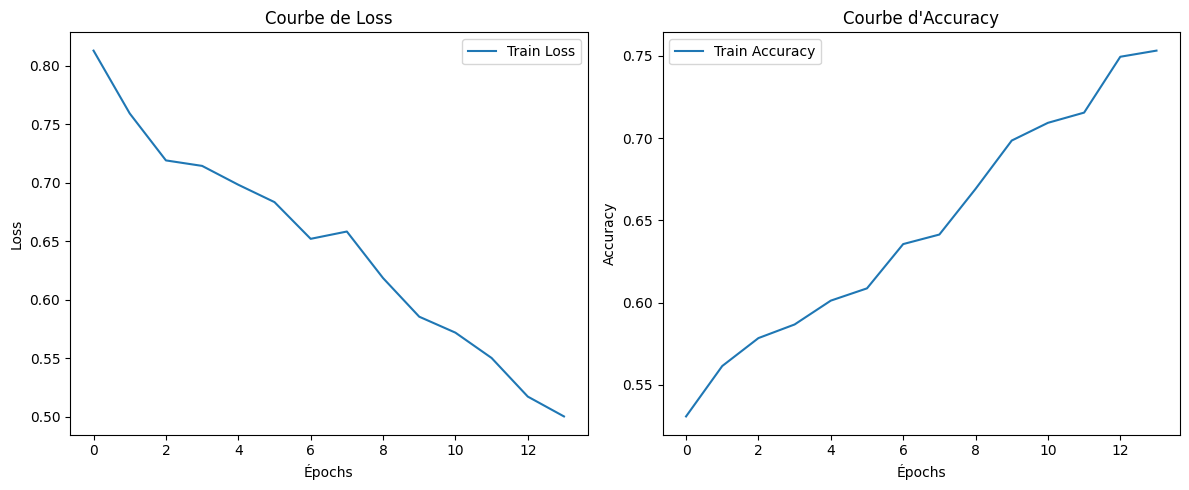

In [19]:
# =========================
# Courbes d'apprentissage
# =========================
plt.figure(figsize=(12,5))

# Courbe de loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Courbe de Loss")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()

# Courbe d'accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
#plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Courbe d'Accuracy")
plt.xlabel("Épochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

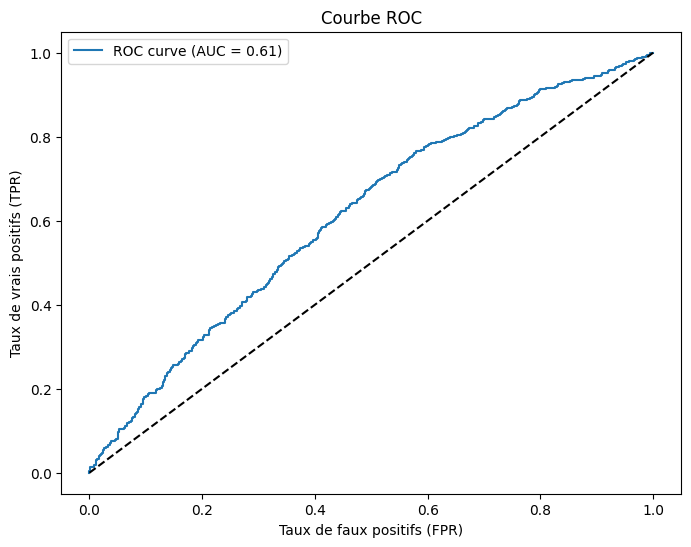

In [ ]:
# =========================
# ROC Curve
# =========================

if multiclass:
    # Calcul ROC pour chaque classe
    n_classes = y_test.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"Classe {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Courbes ROC (multiclasses)")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.legend()
    plt.show()

else:
    # Cas binaire
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title("Courbe ROC")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.legend()
    plt.show()

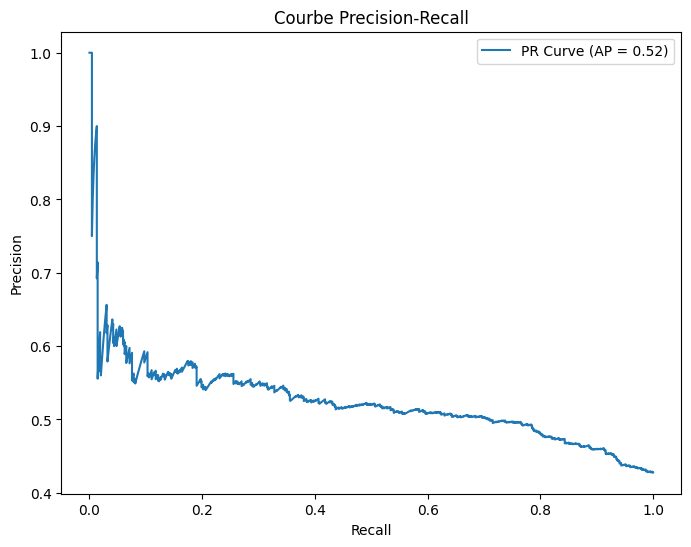

In [ ]:
# =========================
# PR Curve 
# =========================
if multiclass:
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_prob[:, i])
        ap = average_precision_score(y_test[:, i], y_pred_prob[:, i])
        plt.plot(recall, precision, label=f"Classe {i} (AP = {ap:.2f})")

    plt.title("Courbes Precision-Recall (multiclasses)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

else:
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    ap = average_precision_score(y_true, y_pred_prob)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f"PR Curve (AP = {ap:.2f})")
    plt.title("Courbe Precision-Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()